## Cross-device FL with FEDn Part  I: A local development environment for intermittent and asyncronous clients 

In this example we set up a local development environment for experimenting with cross-device use-cases. We will here use FEDn in pseudo-local mode and simulate a fleet of intermittent and asynchronous clients solving a classification problem using incremental learning.

A key feature of this research sandbox is that while experiments are able to run on a single laptop or workstation - the same code will seamlessly transition to distributed and real-world deployments (this we will study in future posts in this series).

In [4]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from client.entrypoint import compile_model, load_parameters, make_data 
from init_seed import make_data, compile_model, load_parameters

from fedn import APIClient
import uuid
import json
import matplotlib.pyplot as plt
import copy

import warnings
warnings.filterwarnings("ignore")

### The ML model

As a centralized model baseline we generate synthetic data for a classification problem with 4 features. We train a MLPClassifier using ReLU activation and Adam as optimizer, on 80k training points, then test on 20k points. A maximum of 1000 epochs is used for centralized training.   

In [5]:
X, y = make_classification(n_samples=100000, n_features=4, n_informative=4, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We train a centralized baseline model for a maximum of 1000 epochs.  

In [6]:
clf = MLPClassifier(max_iter=1000)
clf.fit(X_train, y_train)
central_test_acc = accuracy_score(y_test, clf.predict(X_test))

print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

Training accuracy:  0.9211625
Test accuracy:  0.9195


Next we simulate the FL training procedure each individual FL client will follow. The client will in each iteration (=simulated global round) draw a random number of data points in the interval (n_min, n_max) from (X_train, y_train) and perform 'n_epochs' partial fits on the sampled dataset. Then for each global round we test on the centralized test set (X_test, y_test). In this experiment we simulate 600 global rounds. The client performs 10 local epochs in each round. 

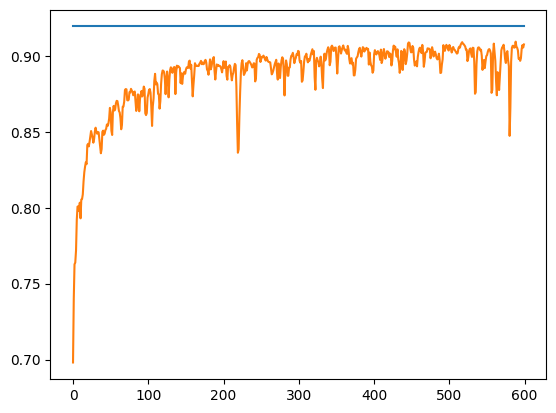

In [7]:
clf = compile_model()

n_global_rounds=600
n_epochs = 10
central_acc_one_client = []
for i in range(n_global_rounds):
    x,y,_,_ = make_data(n_min=10,n_max=100)
    for j in range(n_epochs):
        clf.partial_fit(x, y)
    central_acc_one_client.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(range(n_global_rounds),[central_test_acc]*n_global_rounds)
plt.plot(range(n_global_rounds), central_acc_one_client)

We proceed by simulating the scenario that a number 'n_clients' clients in a fleet of devices send their locally collected/sampled datasets to a central server (we emulate this by scaling n_min and n_max by n_clients). The server then performs incremental learning using the collected data batches (which are thus larger than in the experiment above by a factor n_clients). 

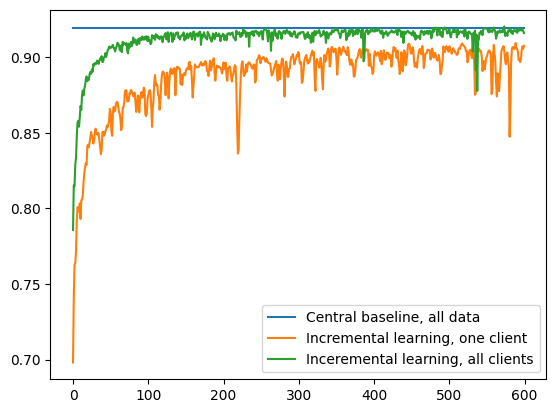

In [8]:
clf = compile_model()

n_global_rounds=600
n_epochs = 10
n_clients = 10
central_acc_all_clients = []
for i in range(n_global_rounds):
    x,y,_,_ = make_data(n_min=n_clients*10, n_max=n_clients*100)
    for j in range(n_epochs):
        clf.partial_fit(x, y)
    central_acc_all_clients.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(range(n_global_rounds),[central_test_acc]*n_global_rounds)
plt.plot(range(n_global_rounds), central_acc_one_client)
plt.plot(range(n_global_rounds), central_acc_all_clients)
plt.legend(['Central baseline, all data','Incremental learning, one client','Inceremental learning, all clients'])

### Federated learning with clients connecting and disconnecting intermittently 

The figure below illustrates the federated learning scenario. We will run clients that: 

- Connect to the server at a random time t_{on}
- Stay online for training for a fixed period of time (e.g one minute).
- Disconnect at time t_{off}. 

This completes one cycle in our setup, which we then repeat a configurable number of cycles. 

![title](img/async-clients.png)

### Running the experiment

Now we run federated learning experiments over a FEDn network. For this we first need to start a pseudo-distributed FEDn network (we can use the provided docker-compose template). To run clients that follow the logic in the illustration above will use the script 'run_clients.py'. This script will start clients running in subprocesses on the host machine. Once clients are up and running, you can proceed below and exectute experiments using the script 'run_experiment.py'. Note that these runs can take some time to complete (600 global rounds for 10 clients took about 1.5h on a 2020 MacBook Pro). 

### Analyzing the resluts using the FEDn APIClient

One the experiment has been started we can use the FEDn APIClient to analyze the result. We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [9]:
DISCOVER_HOST = '100.84.229.36'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Next, we retrive global models for this session and score the models on the central test set. We can use the API client to download model paramters for a given global model_id. We then initialize a model and set the loaded parameters. 

In [23]:
def load_fedn_model(model_id, nr):
    data = client.download_model(model_id, f"models/{nr}_{model_id}.npz")
    parameters = np.load(f"models/{nr}_{model_id}.npz")
    model = compile_model()
    sorted_keys = sorted(parameters.files, key=lambda x: int(x))
    weight_list = [parameters[k] for k in sorted_keys]

    n = len(weight_list)//2
    model.coefs_ = weight_list[:n]
    model.intercepts_ = weight_list[n:]
    return model

By default, 'get_model_trail' returns a list of all models leading up to the current active global model. We iterate over all these models and score them on the centralized test set. 

In [24]:
model_trail = client.get_models()


models = model_trail['result']
print(models)
acc_model_trail = []
nr = 0
for idx in models: 
    nr += 1
    model_id = idx['model']
    print('Model id: ', model_id)
    model = load_fedn_model(model_id, nr)
    acc_model_trail.append(accuracy_score(y_test, model.predict(X_test)))
    print(accuracy_score(y_test, model.predict(X_test)))

[{'committed_at': 'Tue, 22 Apr 2025 19:10:30 GMT', 'model': 'ff5678e8-d091-4b10-84aa-20f14176d9b3', 'model_id': 'ff5678e8-d091-4b10-84aa-20f14176d9b3', 'name': None, 'parent_model': '870406a8-2a4a-477f-85a2-195d445183bd', 'session_id': '1e783a52-a951-4706-9556-8d7b8bd99087'}, {'committed_at': 'Tue, 22 Apr 2025 19:53:09 GMT', 'model': 'fe1b5457-23d6-481d-b021-35294ee4d664', 'model_id': 'fe1b5457-23d6-481d-b021-35294ee4d664', 'name': None, 'parent_model': '914f8068-0df6-4def-8d5d-30d5b72e1449', 'session_id': 'ca0eb913-306d-40bb-a003-3eda6bc59d27'}, {'committed_at': 'Tue, 22 Apr 2025 19:06:47 GMT', 'model': 'fd85fd68-8fae-4a90-a27c-aa23ab913c84', 'model_id': 'fd85fd68-8fae-4a90-a27c-aa23ab913c84', 'name': None, 'parent_model': '8cb36005-e8bd-4c76-885a-bfa834b1f1b3', 'session_id': '1e783a52-a951-4706-9556-8d7b8bd99087'}, {'committed_at': 'Tue, 22 Apr 2025 17:48:15 GMT', 'model': 'fc026787-10ac-41e8-af8f-b08b2058628b', 'model_id': 'fc026787-10ac-41e8-af8f-b08b2058628b', 'name': None, 'paren

In [25]:
client.get_rounds_count()
#client.get_sessions_count()

600

Plot the result. 

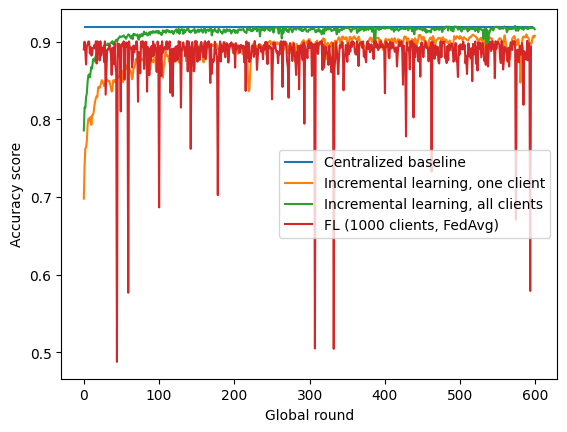

In [13]:
from scipy.interpolate import make_interp_spline


x = range(1, len(acc_model_trail)+1)
plt.plot(x,[central_test_acc]*len(x))
plt.plot(range(n_global_rounds), central_acc_one_client)
plt.plot(range(n_global_rounds), central_acc_all_clients)
plt.plot(range(len(acc_model_trail)),acc_model_trail)
plt.xlabel('Global round')
plt.ylabel('Accuracy score')
plt.legend(['Centralized baseline', 'Incremental learning, one client','Incremental learning, all clients', f'FL ({client.get_clients_count()} clients, FedAvg)'])

As can be seen, FEDn trains a federated model that reaches the same level of performace as the centralized baseline, with convergence close to the simulated case where 10 clients send data to a central server. Here we used FedAdam with a fixed learning rate 1e-2 as the server-side aggregator. It is possible that hyperparameter tuning, or adapting the learning rate, could improve convergence further. This was not the focus of this experiment though - the objective was to set up a pseudo-local experiment environment where clients connect intermittently and validate the robustness of FEDn in this scenario. In future parts of this series we will build on this in different ways as we explore various aspects of cross-device FL.   

In [14]:
client.get_clients_count()

1000

# Visualisation of Experiment

In [65]:
# Load control.rounds.json 
import json
data = []
with open('/Users/sigvard/Desktop/Vinnova/23:4:25 - 1000 Clients 600 rounds/Mongo express DB/control.rounds.json') as f:
    for line in f:
        try:
            data.append(json.loads(line))
            # Process each JSON object here
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")


In [ ]:
# Iterate over the data dict and load: 
# rounds
# nr of aggregated models each round
# time executing training

rounds = []
aggregated_models = []
models_trained = []
time_exec_training = []

for round_data in data:
    rounds.append(round_data['round_id'])
    
    # Number of aggregated models
    nr_aggregated_models = round_data['combiners'][0]['data']['aggregation_time']['nr_aggregated_models']
    aggregated_models.append(nr_aggregated_models)
    
    # Stragglers
    requested_clients = round_data['round_config']['requested_clients']
    
    models_trained.append(requested_clients)
    
    # Time for training
    time_exec_training.append(round_data['combiners'][0]['time_exec_training'])

rounds = list(map(int, rounds))


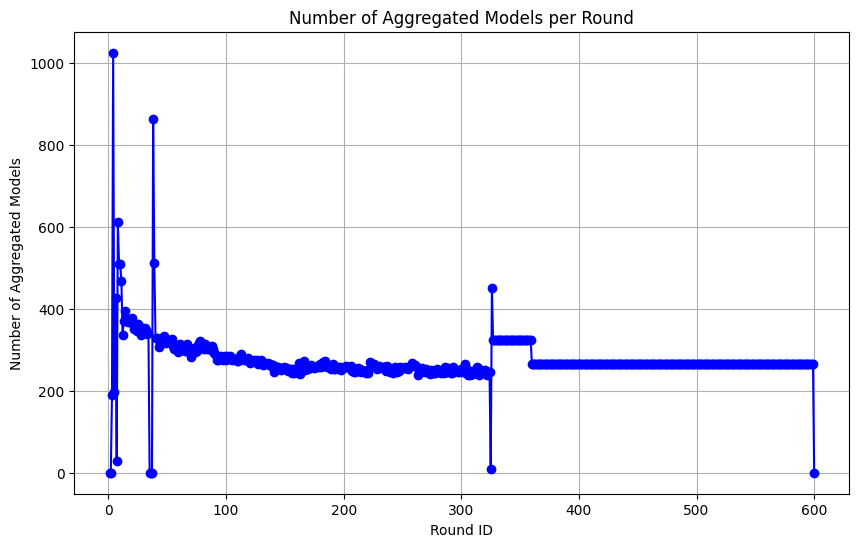

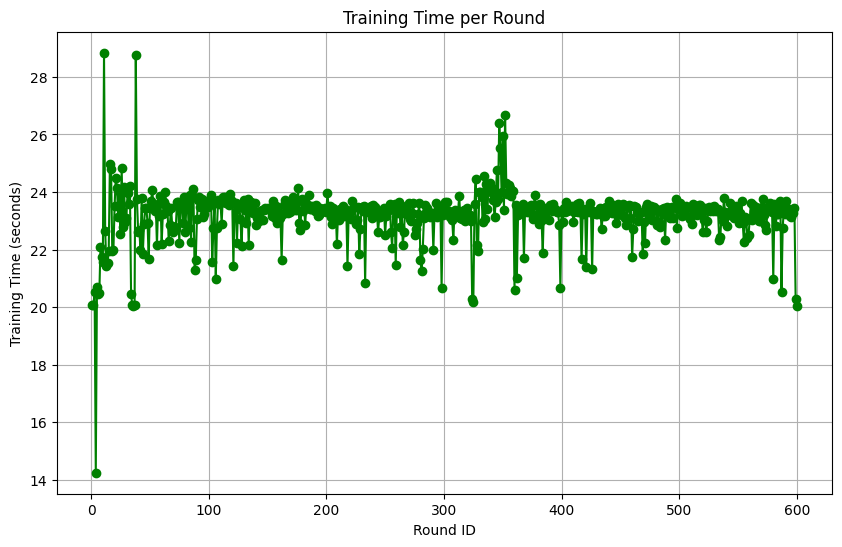

In [67]:
# Number of Aggregated Models per Round
plt.figure(figsize=(10, 6))
plt.plot(rounds, aggregated_models, marker='o', linestyle='-', color='b')
plt.title("Number of Aggregated Models per Round")
plt.xlabel("Round ID")
plt.ylabel("Number of Aggregated Models")
plt.grid(True)
plt.show()


# Training Time per Round
plt.figure(figsize=(10, 6))
plt.plot(rounds, time_exec_training, marker='o', linestyle='-', color='g')
plt.title("Training Time per Round")
plt.xlabel("Round ID")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.show()